### The Dataset is stored in the ```dataset``` folder 
downloaded from ```https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
### Start by importing all the required libraries

In [1]:
"""
Python 3.8.5
Tensorflow 2.2.0
Keras 2.4.3
conda 4.9.0
wordcloud 1.8.0
"""
import configparser
import math
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string # use this to remove punctuation from tweets e.g. string.punctuation
import random as rnd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pickle
import os
import re

"""
Which dataset to use:
1 = IMDB
2 = Sentiment140
"""

DATASET = 2



############ SENTIMENT MODEL TRAINING PARAMETERS ################################
DIMENSION = 300
LEARNING_RATE = 1e-5
BATCH_SIZE = 128
EPOCHS = 60
#################################################################################


############ DATA SPLIT PERCENTAGE ##############################################
TRAINING_SPLIT = 0.80
#################################################################################


############ DATAFILE IS DOWNLOADED (for fresh download set this to False) ######
DATASET_DOWNLOADED = False
#################################################################################


############ NEED TO LIMIT THIS TO 60000 TO ENABLE BUILDING OF DISTANCE MATRIX ##
USE_MAX_VOCABULARY_SIZE = False
MAX_VOCABULARY_SIZE = 60000
#################################################################################

In [32]:
config = configparser.ConfigParser()
config.read('config/main.conf')

if DATASET == 1:
    set_dataset = "imdb"
elif DATASET == 2:
    set_dataset = "s140"

DATASET_URL = (config[set_dataset]['DATASET_URL'])
DATASET_TAR_FILE_NAME = config[set_dataset]['DATASET_TAR_FILE_NAME']
TAR_FILE_PATH = config[set_dataset]['TAR_FILE_PATH']

CLEAN_DATA_FILE_NAME = config[set_dataset]['CLEAN_DATA_FILE_NAME']

DATASET_FOLDER = config[set_dataset]['DATASET_FOLDER']
FOLDER_NAME = config[set_dataset]['FOLDER_NAME']
DATA_SET = config[set_dataset]['DATA_SET']

MODEL_SAVE_PATH = config[set_dataset]['MODEL_SAVE_PATH']
TRAINING_HISORTY_SAVE_PATH = config[set_dataset]['TRAINING_HISORTY_SAVE_PATH']

COUNTER_FITTED_VECTORS = config[set_dataset]['COUNTER_FITTED_VECTORS']
GLOVE_EMBEDDINGS = config[set_dataset]['GLOVE_EMBEDDINGS']

GLOVE_EMBEDDINGS_FILE = config[set_dataset]['GLOVE_EMBEDDINGS_FILE']
COUNTER_FITTED_EMBEDDINGS_FILE = config[set_dataset]['COUNTER_FITTED_EMBEDDINGS_FILE']
 



# Download the dataset and extract contents to correct directories

In [3]:
from manny_train import file_download_extraction as fde


from_folder =""
to_folder = DATA_SET

if DATASET_DOWNLOADED:
    print("If you want to download a fresh copy of the data set,")
    print("make sure the variable DATASET_DOWNLOADED is set to False")
elif DATASET == 1:
    DATASET_DOWNLOADED = True
    fde.download(DATASET_URL, dest_folder=DATASET_FOLDER)
    fde.extract_tar_file(TAR_FILE_PATH, DATASET_FOLDER)
    
    directories_in_dataset_folder = fde.get_directory_name(DATASET_FOLDER)

    if len(directories_in_dataset_folder) == 1:
        from_folder=DATASET_FOLDER+"/"+directories_in_dataset_folder[0]
        fde.rename_folder(from_folder, to_folder)
    else:
        print("ERROR!")
        print(DATASET_FOLDER," folder has too many sub directories!")
        print("Make sure ", DATASET_FOLDER, " is empty before downloading fresh dataset file")
elif DATASET == 2:
    DATASET_DOWNLOADED = True
    fde.download(DATASET_URL, dest_folder=DATASET_FOLDER)
    fde.extract_zip_file(TAR_FILE_PATH, DATASET_FOLDER)
    fde.rename_s140_file(DATASET_FOLDER)
    


Download complete!

Extracting file, please wait...
File extracted in folder:  s140_dataset


# Process dataset
### Read the dataset file and return a data frame and show the first 5 rows of the data frame

In [4]:
from manny_train import IMDB_data_processing as imdb_process
from manny_train import S140_data_processing as s140_process

data_frame = pd.DataFrame
if DATASET == 1:
    data_frame  = imdb_process.process_dataset_IMDB(DATA_SET)
elif DATASET == 2:
    data_frame = s140_process.process_dataset_Sentiment140(DATA_SET)
else:
    print("Please specify which dataset you want to work with...")

data_frame.head()


Loading dataset into pandas Dataframe, please wait ...
Done!


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 25,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

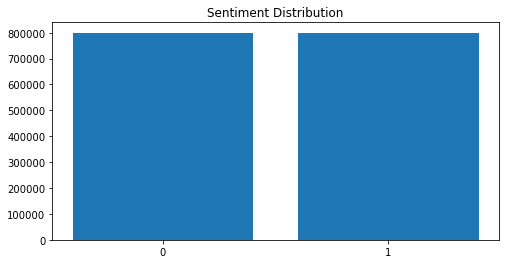

In [5]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xticks(val_count.index)
plt.title("Sentiment Distribution")

# Clean dataset: remove hyperlinks, html entities, punctuation and newline characters ...

In [6]:
from manny_train import clean_text_data as ctd

data_frame = ctd.clean_and_return(data_frame, "text")


Cleaning dataset, please wait ...
Dataset cleaned!


In [7]:
# save the cleaned dataset
data_frame.to_csv(DATASET_FOLDER+"/"+CLEAN_DATA_FILE_NAME, index = False)
data_frame.shape

(1597251, 2)

# Load saved data_frame 

In [8]:
# load the clean dataset from .csv file
dtypes = {'sentiment': 'str', 'text': 'str'}
data_frame = pd.read_csv(DATASET_FOLDER+"/"+CLEAN_DATA_FILE_NAME) # make sure we import both columns as str


# clean data file
data_frame.head()



,sentiment,text
0,0,aw that's a bummer you shoulda got david c...
1,0,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,no it's not behaving at all i'm mad why am...


# Wordcloud of ```positive``` sentiments

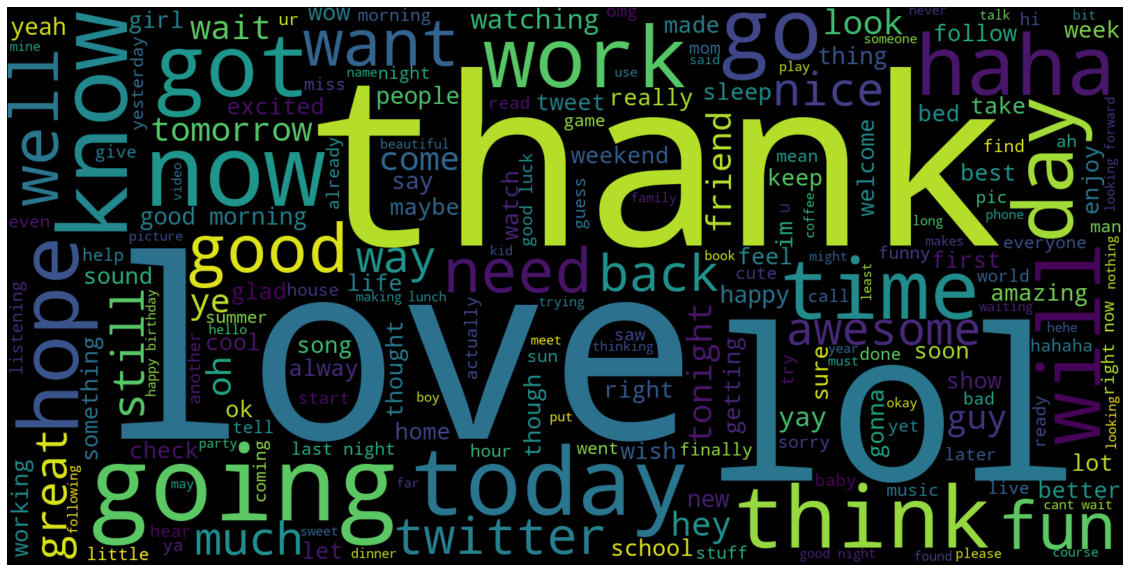

In [9]:
# add aditional stopwords
STOPWORDS.add("film")
STOPWORDS.add("movie")
STOPWORDS.add("one")
STOPWORDS.add("see")
STOPWORDS.add("make")

plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Wordcloud of ```negative``` sentiments

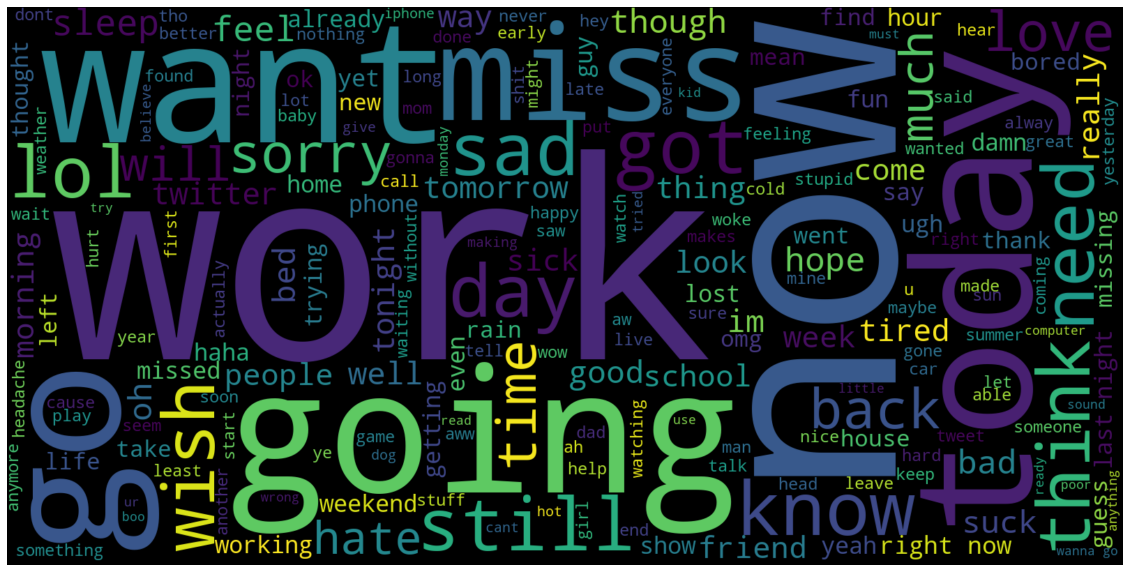

In [10]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Now we need randomise the dataset

In [11]:

data_frame = data_frame.sample(frac = 1, random_state = 7) # frac = 1 i.e. the entire data frame, random_state = Seed for the random number generator 


In [12]:
data_frame.head()


,sentiment,text
1055745,1,yes but if you buy chips from an indian you ...
80913,0,got scolded for not pursuing her plan to go to...
540637,0,man i'm outta the internet loop these days h...
519979,0,can't get to grips with facebook
1158004,1,becoming a papaya fiend next time you see me ...


### Now we split the data set into ```TRAINING_SPLIT``` for training and ```(1 - TRAINING_SPLIT)``` for testing
#### This will also shuffle the data set before splitting it

In [13]:
train_data, test_data = train_test_split(data_frame, test_size= (1 - TRAINING_SPLIT), random_state = 7)

In [14]:
print("Training Data:\t",len(train_data), " data points\t", math.ceil(TRAINING_SPLIT * 100),"%")
print("Test Data:\t",len(test_data), " data points\t", math.ceil((1 - TRAINING_SPLIT) * 100) ,"%")

Training Data:	 1277800  data points	 80 %
Test Data:	 319451  data points	 20 %


### Examine the training and test data sets

#### Training dataset

In [15]:
train_data.head()

,sentiment,text
153655,0,stupid internet its on the go slow
232790,0,out of the shower now and am the coldest im g...
306689,0,it was wonderfully wonderful but now i'm dep...
749629,0,drivin' all ovah the place when i jus wanna g...
1230802,1,mind giving a shoutout he loves you so much ...


#### Testing dataset

In [16]:
test_data.head()

,sentiment,text
480316,0,wells fargo appraisal reevaluation still came ...
268594,0,off to face the pit 'o vipers
742025,0,omgosh im left with a week hate pangsehers
1334478,1,hello if you have any questions hit me
1123035,1,bandits driving to menomnomnom wisconsin




# Tokenization of training data
- We will use the TensorFlow (Keras) Tokenizer class to tokenize our training data (see imports above)
- We define some hyperparameters we will use when performing tokenization
- First we create the Tokenizer object as well as an out of vocabulary token (oov_token) to use for encoding test data words we have not come across in our training, if we don't do this then previously-unseen words would never be unaccounted for. 
- After the Tokenizer has been created, we then fit it on the training data (we do the same for our test dataset).

<center>
<img src="images/tokenization-manning.png">
</center>



    
<center><strong>Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.</strong></center>
    


In [17]:
# hyper parameters provided to tokenizer

"""
the UNK token which will be used for out of vocabulary tokens encountered during the 
tokenizing and encoding of the test data sequences created using the word index built during 
tokenization of our training data.
"""
oov_token = '<UNK>'


"""
When we are encoding our numeric sequence representations of the text data, our tweet
string lengths will be of different lengths and so we will need to select a maximum length 
for tweets and pad shorter tweets with a padding character.

We will first calculate the size of the largest tweet string, and then use '0' as a padding character, to pad out shorter
tweets. This ensures all our sequenes of text are of the same length.

Here are specifying that we want the padding at the end of the sequence of tokens
"""
pad_type = 'post' 

# this is the default, so can just leave this off of the paramteres passed to Tokenizer



In [18]:
# Tokenize training data 
tokenizer = Tokenizer(oov_token=oov_token)

# fit to our training dataset
tokenizer.fit_on_texts(train_data.text)


# store the training datas word_index
"""
The okenization process also creates a word index. This  maps words in our 
vocabulary to their numeric representation.

This mapping is then used to encoding our sequences. 
"""
word_index = tokenizer.word_index


"""
Set the maximum vocabulary size to use.
"""
if USE_MAX_VOCABULARY_SIZE:
    MAX_VOCABULARY_SIZE = tokenizer.word_index + 1
else:
    MAX_VOCABULARY_SIZE = MAX_VOCABULARY_SIZE

    
    
# Encode the training tweet sentence into sequences
"""
After tokenizing our training data we have a word-to-numeric 
mapping of our vocabulary, this is used to encode our sequences. 

Here, we are converting our text sentences from something  like 
"the cat sat on the mat" to something like "3 6 7 2 1 4" where each of 
these numbers matches to the index of the corresponding words. 

Since Neural Networks work erforming computation on numbers, 
passing in set of strings will not work. Which is why we need these sequences.

So far, this is only the training dataset, the test dataset has to be
tokenized and encoded after we have competed the training dataset.
"""
initial_train_sequences = tokenizer.texts_to_sequences(train_data.text)
# we need to make sure the sequence size matches the setting for vocabulary size
# otherwise we will get an index out of counds error when we try to train the model
train_sequences = [[w if w < MAX_VOCABULARY_SIZE else MAX_VOCABULARY_SIZE for w in doc] for doc in initial_train_sequences]

initial_test_sequences = tokenizer.texts_to_sequences(test_data.text)
# we need to make sure the sequence size matches the setting for vocabulary size
# otherwise we will get an index out of counds error when we try to train the model
test_sequences = [[w if w < MAX_VOCABULARY_SIZE else MAX_VOCABULARY_SIZE for w in doc] for doc in initial_test_sequences]



# Get max training and test sequence length and find the maximum value to use for padding
# dataset has a longer sequence - we don't want it truncated)
"""
To ensure that all our sequences are of the same length, we need to set the 
maxlen hyperparameter. Here we set it to twice the maximum length found in
our training dataset sequences.
"""

maxlen_test = max([len(x) for x in train_sequences])
maxlen_train = max([len(x) for x in train_sequences])

# set to max of the two values from the training and test sets
maxlen = max(maxlen_test,maxlen_train)

# make sure maxlen is divisible by BATCH_SIZE
while True:
    if (maxlen % BATCH_SIZE) != 0:
        maxlen += 1
    else:
        break

# Pad the training and test sequences
"""
The encoded sequences need to be the same length. 

We use the maxlen found above to set this length. This will 
pad all other sequences with extra '0's at the end ('post').
"""
train_x = pad_sequences(train_sequences, padding=pad_type, maxlen=maxlen)
test_x = pad_sequences(test_sequences, padding=pad_type, maxlen=maxlen)


# Check results of tokenization and creation of training and test sequences

In [19]:

print("Padded Training Shape:", train_x.shape,"\n")
print("maxlen (maximum length of training sequences):", maxlen)


print("\nExample Training Sequences:\n",train_sequences[1])
print("\nExample Padded Training Sequences:\n",train_x[0])

print("\n##################################################################\n")

print("Padded Testing Shape:", test_x.shape,"\n")
print("maxlen (maximum length of test sequences):", maxlen)

print("\nExample Testing sequences:\n",test_sequences[5])
print("\nExample Padded Testing Sequences:\n",test_x[9])


Padded Training Shape: (1277800, 128) 

maxlen (maximum length of training sequences): 128

Example Training Sequences:
 [33, 13, 4, 564, 28, 7, 51, 4, 20474, 59, 46, 3, 23, 34, 31, 68, 25, 795]

Example Padded Training Sequences:
 [393 515  68  14   4  38 759   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]

##################################################################

Padded Testing Shape: (319451, 128) 

maxlen (maximum length of test sequences): 128

Example Testing sequences:
 [4798, 360, 1259, 12, 1293]

Example Padded Testing Sequences:
 

### Length of vocabulary (i.e. all tokenized words)

In [20]:
print(len(tokenizer.word_index))


262307


# Print the first entry only, to show the actual text as a padded sequqnce

In [21]:
for x, y in zip(test_data.text, test_x):
    print('{} \n\n -- to padded sequence --> {}'.format(x, y))
    break

wells fargo appraisal reevaluation still came in at original appraised value  offers and this  aren't we working hard enough  

 -- to padded sequence --> [ 7260 29808 25595     1    70   431    12    24  1899     1  4045  5607
     7    27   777    57   169   291   396     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


### There are only two labels in our model (0 = negative, 1 = positive)

In [22]:
print(train_data.sentiment.unique().tolist())


[0, 1]


### Encode training labels using scikit-learn module sklearn.preprocessing.LabelEncoder
#### to make sure we have only numeric values for labels

In [23]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

train_y = encoder.transform(train_data.sentiment.to_list())
test_y = encoder.transform(test_data.sentiment.to_list())
# print("Dimensions before reshape: ",train_y.ndim)

# convert the 1 dimensional array into a 2d array as required for training 
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

# print("Dimensions after reshape: ",train_y.ndim)
print("train_y shape:", train_y.shape)
print("test_y shape:", test_y.shape)


train_y shape: (1277800, 1)
test_y shape: (319451, 1)


# Word-Embeddings
#### Word embeddings is a feature vector for each of the words that enables us to give words a ```context```.
- Instead of creating this ourselves, we will use a pre-trained embddings vectors (GloVe Embeddings)


# Functions to:
- #### Create and return an embeddings model as a dictionary ```def load_embeddings_model(embeddings_file: str) -> dict:```
- #### Create and return an embeddings matrix ```def get_embeddings_matrix(embeddings_file: str, max_vocabulary_size: int, dimension=300) -> np.ndarray:```
- #### Save a numpy array to file ```def save_numpy_array_to_file(full_path_to_file: str, max_vocabulary_size: int, npy_array: np.ndarray):```

In [24]:
# If we have enough memory on server can set this to length of words produced by tokenizer
# MAX_VOCABULARY_SIZE = len(tokenizer.word_index) + 1

def return_all_dictionaries():
    """
    return tokenized words as a set of dictionaries, to make look-up of words easier
    """
    data_dictionary = dict()
    inv_data_dictionary = dict()

    data_dictionary['UNK'] = MAX_VOCABULARY_SIZE
    inv_data_dictionary[MAX_VOCABULARY_SIZE] = 'UNK'

    for word, idx in tokenizer.word_index.items():
        if idx < MAX_VOCABULARY_SIZE:
            inv_data_dictionary[idx] = word
            data_dictionary[word] = idx
      
    return data_dictionary, inv_data_dictionary
    
    
def load_embeddings_model(embeddings_file: str) -> dict:
    embeddings_model= {}
    
    print("Loading embeddings model to dictionary, please wait...")
    with open(embeddings_file, 'r', encoding="utf8") as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_model[word] = coefs

    print("Finished!")
    print('Found %s word vectors in model.' %len(embeddings_model))
    return embeddings_model


    
def get_embeddings_matrix(embeddings_file: str, dictionary: dict, dimension: int) -> np.ndarray:
    
    max_vocabulary_size = len(dictionary) + 1
    print("max_vocabulary_size: ",max_vocabulary_size)
    # load a pre-trained embeddings model into a dictionary
    embeddings_model = load_embeddings_model(embeddings_file)
    
    print("\nCreating embeddings matrix ...")
    embedding_matrix = np.zeros((max_vocabulary_size, dimension)) 
    
    for word, i in dictionary.items():
        embedding_vector = embeddings_model.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print("Finished!")        
    return embedding_matrix
    


def save_numpy_array_to_file(full_path_to_file: str, max_vocabulary_size: int, npy_array: np.ndarray):
    
    print("Saving file please wait...")
    full_path_to_file = full_path_to_file+"_%d.npy" % max_vocabulary_size
    np.save(full_path_to_file,npy_array) 
    print("Finished!")
    print("Saved file to: ",full_path_to_file)
    
    
def counter_embeddings_dictionary(counter_fitted_file: str):
    embeddings_dict = {}
    with open(counter_fitted_file, 'r') as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            #print(word)
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict
    


### Check and make sure we have set ```MAX_VOCABULARY_SIZE``` 

In [25]:
print(MAX_VOCABULARY_SIZE)

60000


# Create embeddings matrix of words found in IMDB dataset

In [26]:
#g_matrix = bemd.create_embeddings_matrix(glove_model, dictionary, full_dictionary, d=300)
data_dictionary, inv_data_dictionary = return_all_dictionaries()

glove_embeddings_matrix = get_embeddings_matrix(GLOVE_EMBEDDINGS, data_dictionary, DIMENSION)


max_vocabulary_size:  60001
Loading embeddings model to dictionary, please wait...
Finished!
Found 2196007 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of GloVe embeddings matrix

In [26]:
glove_embeddings_matrix.shape

(60001, 300)

### Make sure the ```data_dictionary``` returns the correct values

In [27]:
# make sure our dictionaries contain the correct values
print(data_dictionary["movies"])
print(inv_data_dictionary[data_dictionary['movies']])


99
movies


### Save GloVe Embeddings Matrix to file

In [29]:

# save glove embeddings for words found to the embedding directory
full_path_to_file = "embeddings/"+GLOVE_EMBEDDINGS_FILE
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, glove_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/S140_glove_embeddings_60000.npy


# Create attack embeddings matrix for our vocabulary
#### (This will be used when generating attacks against the model)

In [30]:

counter_embeddings_matrix = get_embeddings_matrix(COUNTER_FITTED_VECTORS, data_dictionary, DIMENSION)


max_vocabulary_size:  60001
Loading embeddings model to dictionary, please wait...
Finished!
Found 65713 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of our vocabulary matrix

In [31]:

print(counter_embeddings_matrix.shape)


(60001, 300)


### Save our vocabulary embeddings matrix

In [33]:

# save the counter fitted embeddings for words found
full_path_to_file = "embeddings/"+COUNTER_FITTED_EMBEDDINGS_FILE
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, counter_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/S140_counter_fitted_embeddings_60000.npy


# Check we have a GPU available for traiing the model
#### (If no GPU available then training will be done using the CPU, which is very slow!)

In [32]:
print("Number of GPUs available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if tf.test.gpu_device_name(): 
    print('GPU Device used for training will be: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU, make sure using a GPU enabled machine, or check you have GPU version of Tensorflow")

Number of GPUs available:  1
GPU Device used for training will be: /device:GPU:0


# Train the sentiment analysis model and save it to ```MODEL_SAVE_PATH```
### weights used during training are form the GloVe embeddings, so pass that in as a paramter

In [34]:

# get the saved GloVe embeddings matrix
glove_embeddings_matrix = np.load(("embeddings/"+GLOVE_EMBEDDINGS_FILE+"_%d.npy" % MAX_VOCABULARY_SIZE))


In [35]:

print("glove_embeddings_matrix shape: ",glove_embeddings_matrix.shape)


glove_embeddings_matrix shape:  (60001, 300)


In [ ]:
from  manny_train import models

# this shape must match the glove_embeddings_matrix shape
# because we are using the glove_embeddings_matrix as the vector of weights in out training
input_dimension, dimension = glove_embeddings_matrix.shape

if input_dimension != MAX_VOCABULARY_SIZE + 1:
    print("ERROR: tensore shape is not correct!")
    print("Possible cause: Check the sequence length after tokenizing!")

print("Using Learning Rate: ",LEARNING_RATE)
model_test = models.TrainModel(glove_embeddings_matrix,
                                train_x, train_y, test_x, test_y,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                input_dim=input_dimension,
                                input_length=maxlen,
                                trainable=True,
                                output_dim=dimension,
                                learning_rate=LEARNING_RATE
                               )



Using Learning Rate:  1e-05
Building model, please wait ...

Training on GPU...
Epoch 1/60
9983/9983 [==============================] - 1871s 187ms/step - loss: 0.5316 - accuracy: 0.7340 - val_loss: 0.4690 - val_accuracy: 0.7794 - lr: 1.0000e-05
Epoch 2/60
9983/9983 [==============================] - 1879s 188ms/step - loss: 0.4767 - accuracy: 0.7723 - val_loss: 0.4460 - val_accuracy: 0.7924 - lr: 1.0000e-05
Epoch 3/60
9983/9983 [==============================] - 1883s 189ms/step - loss: 0.4578 - accuracy: 0.7841 - val_loss: 0.4347 - val_accuracy: 0.7998 - lr: 1.0000e-05
Epoch 4/60
9983/9983 [==============================] - 1878s 188ms/step - loss: 0.4462 - accuracy: 0.7915 - val_loss: 0.4274 - val_accuracy: 0.8027 - lr: 1.0000e-05
Epoch 5/60
9983/9983 [==============================] - 1860s 186ms/step - loss: 0.4375 - accuracy: 0.7962 - val_loss: 0.4215 - val_accuracy: 0.8062 - lr: 1.0000e-05
Epoch 6/60
9983/9983 [==============================] - 1873s 188ms/step - loss: 0.4308 - 

In [ ]:
from keras.models import load_model
import pickle

history_dict = model_test.history_dict
model = model_test.model

# save the model outside of git directory - so we don't try and push to github
model.save(MODEL_SAVE_PATH)  # creates a HDF5 file 'my_model.h5'

# save history as a dictionary in case we need to plot again later
with open(TRAINING_HISORTY_SAVE_PATH, 'wb') as file_pickle:
        pickle.dump(history_dict.history, file_pickle)


In [ ]:
# Model.fit(
#     x=None,
#     y=None,
#     batch_size=None,
#     epochs=1,
#     verbose=1,
#     callbacks=None,
#     validation_split=0.0,
#     validation_data=None,
#     shuffle=True,
#     class_weight=None,
#     sample_weight=None,
#     initial_epochMAX_VOCABULARY_SIZE#     steps_per_epoch=None,
#     validation_steps=None,
#     validation_batch_size=None,
#     validation_freq=1,
#     max_queue_size=10,
#     workers=1,
#     use_multiprocessing=False,
# )


# Evaluate the model

In [ ]:
# s, (at, al) = plt.subplots(2,1)

# at.plot(history_dict.history['accuracy'], c= 'b')
# at.plot(history_dict.history['val_accuracy'], c='r')
# at.set_title('model accuracy')
# at.set_ylabel('accuracy')
# at.set_xlabel('epoch')
# at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

# al.plot(history_dict.history['loss'], c='m')
# al.plot(history_dict.history['val_loss'], c='c')
# al.set_title('model loss')
# al.set_ylabel('loss')
# al.set_xlabel('epoch')
# al.legend(['train', 'val'], loc = 'upper left')
# s.show()

In [ ]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(test_x, verbose=1, batch_size=BATCH_SIZE)
y_predictions = [decode_sentiment(score) for score in scores]


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes, title='Confusion Matrix',cmap=plt.cm.Greys, normalize=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontsize=22)
    plt.xlabel('Predicted', fontsize=17)

In [ ]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_predictions)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.savefig('images/imdb-confusion-matrix.png',bbox_inches='tight')
plt.show()



In [ ]:
print(classification_report(list(test_data.sentiment), y_predictions))

# Save the model
we can later load it from disk

In [43]:
from keras.models import load_model
model = load_model(MODEL_SAVE_PATH)
history_dict = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))

In [ ]:

model.summary()


In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,7))
plt.plot(epochs, loss,'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/S140-training-and-validation-loss.png',bbox_inches='tight')
plt.show()


In [ ]:
plt.clf()   # clear figure
plt.figure(figsize=(12,7))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('images/S140-training-and-validation-accuracy.png',bbox_inches='tight')
plt.show()


# At this point we have saved the clean dataset file, model and history of the training 
### Now we can just load the model, when we need it for generating adversarial examples against it

In [47]:
model = load_model(MODEL_SAVE_PATH)
history_dict = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))

In [48]:
print(GLOVE_EMBEDDINGS)

glove/glove.840B.300d.txt


In [49]:
counter_embeddings_matrix  = get_embeddings_matrix(COUNTER_FITTED_VECTORS, data_dictionary, DIMENSION)
#counter_dict = counter_embeddings_dictionary(COUNTER_FITTED_VECTORS)

max_vocabulary_size:  60001
Loading embeddings model to dictionary, please wait...
Finished!
Found 65713 word vectors in model.

Creating embeddings matrix ...
Finished!


In [161]:
import numpy as np
counter_embeddings_matrix = np.load(("embeddings/imdb_counter_fitted_embeddings_%d.npy" % MAX_VOCABULARY_SIZE))
#print(find_closest_embeddings(data_dictionary["movies"])[1:10])


print(type(counter_embeddings_matrix))
print(counter_embeddings_matrix.shape)

<class 'numpy.ndarray'>
(60001, 300)


# Generate and save word distance matrix
#### l2 distance: $(x-y)^2$ expand this out and we get: $x^2 + y^2 - 2xy$ using this to calculate euclidian (l2) distance between vectors



In [162]:
def distance_matrix(matrix):
    dists = -2 * np.dot(matrix, matrix.T) + np.sum(matrix**2,    axis=1) + np.sum(matrix**2, axis=1)[:, np.newaxis]
    return dists

In [60]:
"""
THIS IS WHY WE HAVE TO REDUCE THE VOCABULARY SIZE - WE NEED TO ALLOCATE ENOUGH SPACE FOR THIS MATRIX
IF WE USE THE FULL VOCABULARY SIZE - WE WILL NOT BE ABLE TO ALLOCATE ENOUGH MEMORY FOR THE SIZE OF THE MATRIX
THAT WILL BE GENERATED
"""
square_matrix = -2 * np.dot(counter_embeddings_matrix, counter_embeddings_matrix.T)
print(len(square_matrix))

60001


In [61]:
a = np.sum(np.square(counter_embeddings_matrix), axis=1).reshape((1,-1))

In [62]:
b = a.T

In [63]:
square_matrix.shape

(60001, 60001)

In [64]:
a.shape

(1, 60001)

In [65]:
b.shape

(60001, 1)

# Save the distance matrix

In [66]:
dist = a + b + square_matrix

In [67]:
np.save(('embeddings/distance_counterfitted_embeddings_%d.npy' % MAX_VOCABULARY_SIZE), dist)

In [90]:
np.amax(dist)

2.859412738646227

In [92]:
np.amin(dist)

-8.881784197001252e-16

# Closest words in disrtance matrix, and their distances

In [91]:
from manny_train import build_embeddings as bemb

for r in range(100,105):
    source_word = r
    
    nearest_neighbour, distance_to_neighbour = bemb.closest_neighbours(source_word, dist, ret_count=5)
    
    print("Nearest Neighbours to `%s` are:" %inv_data_dictionary[source_word])
    
    for word_index, distance in zip(nearest_neighbour,distance_to_neighbour):
        print("\t--> ", inv_data_dictionary[word_index], "     ", distance)
    print("----------------------------------------------------------------\n")



Nearest Neighbours to `after` are:
	-->  subsequently       0.19739067975234348
	-->  afterward       0.21351224306351346
	-->  thereafter       0.21713814789663277
	-->  afterwards       0.22155526197445496
	-->  upon       0.23389274616020228
----------------------------------------------------------------

Nearest Neighbours to `think` are:
	-->  thought       0.15096381446318552
	-->  thoughts       0.19772474379935123
	-->  reckon       0.2158823221500985
	-->  thinks       0.25389518633056785
	-->  believe       0.27684226527503797
----------------------------------------------------------------

Nearest Neighbours to `characters` are:
	-->  personages       0.06438505936322758
	-->  character       0.07006674850581618
	-->  traits       0.11063837435466573
	-->  nature       0.17886766452615865
	-->  trait       0.21602845788842173
----------------------------------------------------------------

Nearest Neighbours to `watch` are:
	-->  surveillance       0.5249733280639659
	-->

In [71]:
dist_order = np.argsort(dist[src_word, :])[1:8]
print(dist_order)

[   19  1493   104    99   444 10300  1238]
